In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow_datasets as tfds
import os
import matplotlib.pyplot as plt
import vd_generator
import tqdm

c:\Users\ual\.conda\envs\felix\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model = tf.keras.models.load_model("training_results/last_model/ENB0_All/model")
model.load_weights("training_results/weights/ENB0_All/cp.ckpt")

In [4]:
_,val_ds = vd_generator.get_train_and_val()


In [5]:
model.evaluate(val_ds)

169/169 [==============================] - 15s 40ms/step - loss: 0.1952 - accuracy: 0.9365


[0.19517731666564941, 0.9364829659461975]

In [8]:
inputs = tf.keras.Input([260,260,3])
x = tf.keras.layers.Resizing(224,224) ( inputs)

base = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_tensor= x)

base.trainable = False
# Rebuild top
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(base.output)
x = tf.keras.layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = tf.keras.layers.Dense(2, activation="softmax", name="pred",kernel_regularizer=tf.keras.regularizers.L2())(x)

# Compile
with_out_aug_model = tf.keras.Model(inputs, outputs, name="with_out_aug")
for layer in with_out_aug_model.layers[-20:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

In [9]:
for old,new in zip(model.layers[2:],with_out_aug_model.layers[1:]):

    try:
        with_out_aug_model.get_layer(new.name).set_weights(model.get_layer(old.name).get_weights())
    except:
        print(new.name)
with_out_aug_model.compile(tf.keras.optimizers.Adam(),loss = tf.keras.losses.BinaryCrossentropy(),metrics=["accuracy"])
with_out_aug_model.evaluate(val_ds)

169/169 [==============================] - 8s 38ms/step - loss: 0.1952 - accuracy: 0.9365


[0.19517731666564941, 0.9364829659461975]

In [10]:
test_ds = vd_generator.get_test_ds()
model.evaluate(test_ds)

167/167 [==============================] - 7s 42ms/step - loss: 0.2697 - accuracy: 0.9094


[0.2697361707687378, 0.9094311594963074]

In [13]:
preds = np.argmax(with_out_aug_model.predict(test_ds),axis=1)
_,val_df,test_df = vd_generator.get_csv()
to_numbers ={"Forward":0, "Backward":0,"Sideways":1}
labels = test_df["view_direction"].map(to_numbers)[:len(preds)]
failure_mask = preds != labels
failed_images = test_df[:len(preds)][failure_mask]
wrong_preds = preds[failure_mask]
wrong_labels = labels[failure_mask]
imgs = np.concatenate([i for i,a in tfds.as_numpy(test_ds)])
len(failed_images)

968

In [17]:
dic

{0: 'Backward', 1: 'Sideways'}

In [33]:
preds[18:]

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

In [31]:
preds.argmax()

18

In [29]:
sum(wrong_labels[584:])

384

In [26]:
wrong_labels[:584].sum()

0

In [25]:
wrong_labels.argmax()

584

 26%|██▋       | 255/968 [03:43<10:25,  1.14it/s]


KeyboardInterrupt: 

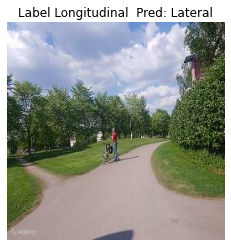

In [23]:
dic = {0: "Longitudinal",1:"Lateral"}


def save_n_wrong_images(n):

    image = np.choice(range(n),n,replace=False)

    for i in tqdm.tqdm(image):

        plt.imshow(imgs[failure_mask][i])
        plt.axis('off')

        label = dic[wrong_labels.values[i]]
        pred = dic[wrong_preds[i]]

        plt.title(f"Label {label}  Pred: {pred}")
        plt.savefig(f"../wrong_labels/{test_df.iloc[i,0]}.jpg")

save_n_wrong_images(968)

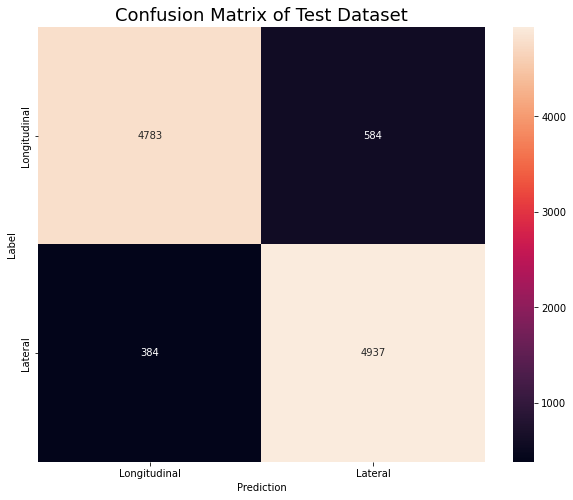

In [20]:
confusion_mtx = tf.math.confusion_matrix(labels,preds)
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

names = list(dic.values())

sns.heatmap(confusion_mtx, xticklabels=names, yticklabels=names, 
          annot=True, fmt='g')
plt.title("Confusion Matrix of Test Dataset",fontsize=18)
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.savefig("../Imgs/Confusion_Matrix.jpg")
plt.show()

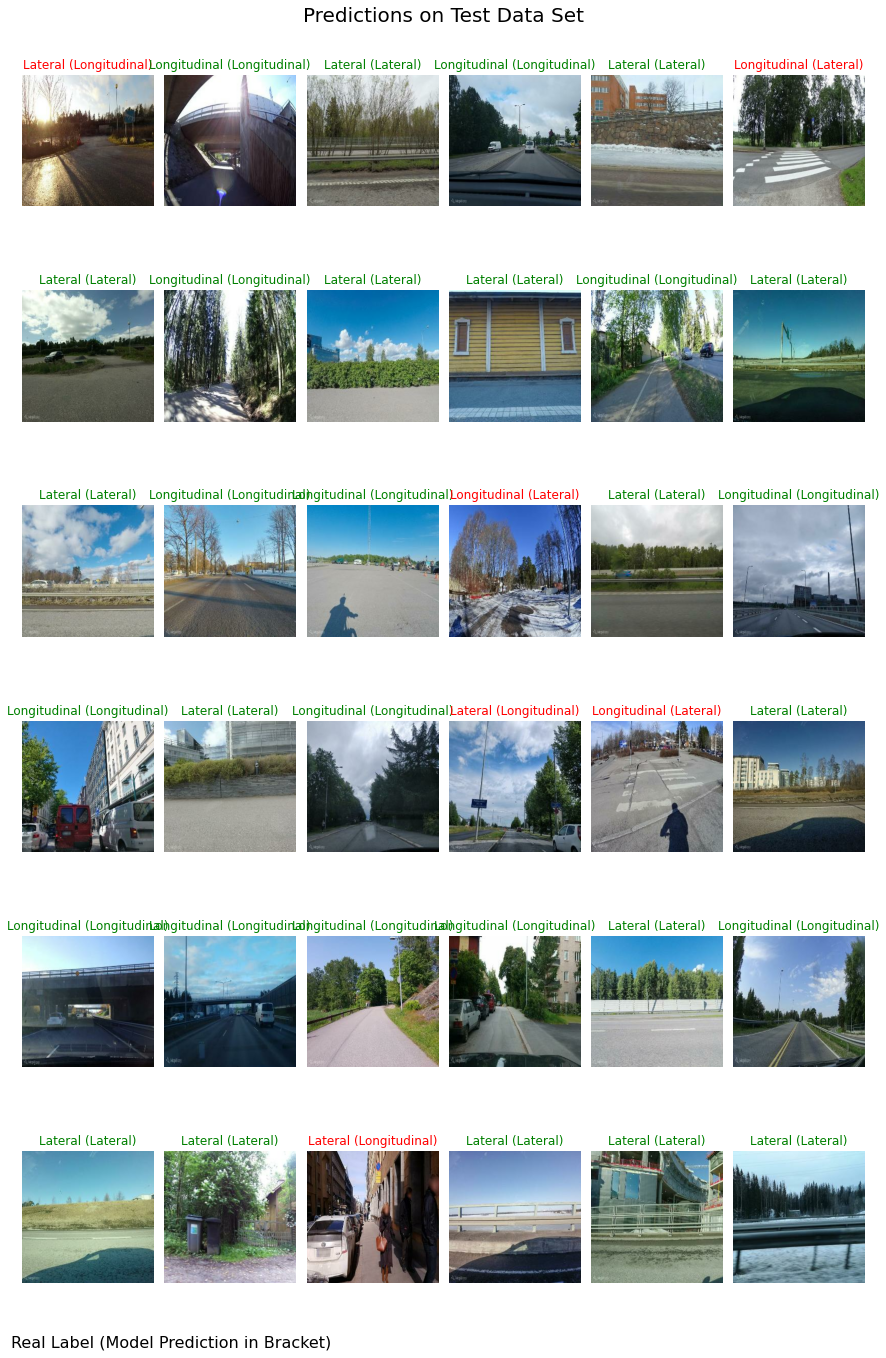

In [21]:
n_row, n_col = 6,6

n_imgs = n_row * n_col

get_names = dic

_, axs = plt.subplots(n_row, n_col, figsize=(12, 19))
axs = axs.flatten()

for i,j in enumerate(np.random.choice(range(len(preds)),n_imgs,replace=False)):
    ax = axs[i]
    
    l = get_names[labels.values[j]]
    p = get_names[preds[j]]
    color = "green" if l==p else "red"
    
    ax.imshow(imgs[j])
    ax.axis("off")
    ax.set_title(f"{l} ({p})",color=color)
    
plt.suptitle("Predictions on Test Data Set",fontsize=20)
plt.figtext(0,0,"Real Label (Model Prediction in Bracket)",fontsize=16)
plt.tight_layout()
plt.savefig("../Imgs/Predictions.jpg")
plt.show()